## Imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier

## Read in Data

In [2]:
df = pd.read_csv('./Data/no_removed.csv')

In [3]:
df.head()

,title,selftext,subreddit,text
0,Any insight on how to handle a coworker trying...,"So over the past month or so, I’ve gotten pret...",0,Any insight on how to handle a coworker trying...
1,"Women of reddit, what are you really getting o...",I just became curious because I saw this porn ...,0,"Women of reddit, what are you really getting o..."
2,How far would you go for love?,I recently was asked out by a guy Im really fo...,0,How far would you go for love?I recently was a...
3,"Menly men of askmen, what's a unique thing you...",NaN,0,"Menly men of askmen, what's a unique thing you..."
4,How would you react if your barista gave you h...,Hi! So I work as a barista and have a regular ...,0,How would you react if your barista gave you h...


In [4]:
x = df['text'] #titles and self text combined
y = df['subreddit']

In [5]:
df['subreddit'].value_counts(normalize=True)

0    0.523839
1    0.476161
Name: subreddit, dtype: float64

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 13, stratify = y)

## TFID and LR

In [7]:
tf = TfidfVectorizer(max_df=.8, min_df=2, ngram_range=(1, 4), stop_words='english', max_features=3000)
lr = LogisticRegression(random_state=13)

x_train_tf = tf.fit_transform(x_train)
x_test_tf = tf.transform(x_test)

lr.fit(x_train_tf, y_train)

print(lr.score(x_train_tf, y_train))

lr.score(x_test_tf, y_test)

0.8545232273838631


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6858190709046454

## Checking Results

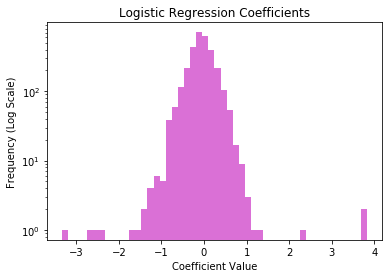

In [8]:
coefs = pd.DataFrame(tf.get_feature_names(),columns=['word'])
coefs['beta'] = lr.coef_[0]
plt.hist(coefs['beta'], log=True, bins=50, color = 'orchid');
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency (Log Scale)')
plt.title('Logistic Regression Coefficients');

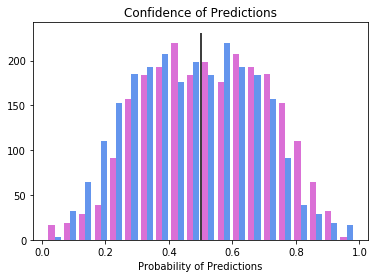

In [9]:
plt.title('Confidence of Predictions')

plt.xlabel('Probability of Predictions')

pred_y = lr.predict_proba(x_train_tf)
plt.hist(pred_y, bins=20, color = ['orchid', 'cornflowerblue']);
plt.vlines(0.5, plt.ylim()[0], plt.ylim()[1] );

In [10]:
#check out coefficients

In [76]:
lr.coef_.sort()

In [73]:
lr.coef_

array([[-1.45247733, -1.22363469, -0.86965327, -0.8061186 , -0.46678661,
        -0.39166536, -0.27989669,  0.0346684 ,  0.07132259,  0.14726638,
         0.16085373,  0.23399408,  0.33050654,  0.34434745,  0.44266204,
         0.5304133 ,  0.71335623,  0.79647962,  1.06622037,  1.38956363]])

In [12]:
probas = lr.predict_proba(x_test_tf)[:,0]

In [13]:
preds = lr.predict(x_test_tf)

In [14]:
probs_df = pd.DataFrame(probas, columns = ['probabilities'])

In [15]:
y_df = pd.DataFrame (y_test) 

In [16]:
probs_df['prediction'] = preds

In [17]:
probs_df = probs_df.merge(y_df, left_index=True, right_index=True )

In [18]:
probs_df.columns

Index(['probabilities', 'prediction', 'subreddit'], dtype='object')

In [19]:
probs_df[probs_df['prediction'] != probs_df['subreddit']].sort_values(by = 'probabilities', ascending = False)

,probabilities,prediction,subreddit
743,0.498285,1,0
766,0.498022,1,0
502,0.494108,1,0
653,0.486763,1,0
678,0.486358,1,0
...,...,...,...
679,0.147759,1,0
805,0.125905,1,0
493,0.121663,1,0
558,0.094583,1,0


In [20]:
y_test.index[679]

2006

In [21]:
df.iloc[679]['text']

"Men of Reddit: how do you deal with finding your girlfriend or wife's hair absolutely everywhere and on everything?"

## CVEC with Random Forest

In [22]:
cvec = CountVectorizer(stop_words='english', ngram_range= (1, 2), min_df=2, max_df=.8)

x_train_cvec = cvec.fit_transform(x_train)

x_test_cvec = cvec.transform(x_test)

rf = RandomForestClassifier(max_features=2000, n_estimators=200)

rf.fit(x_train_cvec, y_train)

print(rf.score(x_train_cvec, y_train))

rf.score(x_test_cvec, y_test)

0.9975550122249389


0.6797066014669927

## Checking TFID DataFrame

In [23]:
num_subreddits = df['text'].map(lambda x: 'like' in x.lower())

In [24]:
num_subreddits.sum()

761

In [25]:
tf = TfidfVectorizer(
    #max_features=2000, 
    #stop_words='english', 
    #ngram_range=(1, 2)
)

x_train_tf = tf.fit_transform(x_train)

x_train_tf.toarray().shape

tf_df = pd.DataFrame(x_train_tf.toarray(), columns = tf.get_feature_names())

In [26]:
pd.DataFrame(x_train_tf.toarray(), columns = tf.get_feature_names()).sum(axis =0)

00        0.262602
01        0.262602
10        3.242075
100       2.660444
1000      0.091177
            ...   
zodiac    0.145700
zoloft    0.099582
zombie    0.262602
zone      0.520205
zones     0.046335
Length: 8122, dtype: float64

In [27]:
tf_df.sum().sort_values(ascending = False).head(10) 

you     176.366594
to      151.143962
and     124.969342
what    122.602977
the     119.953335
do      107.119891
your     99.238341
it       92.921790
of       92.595548
how      84.486674
dtype: float64

In [28]:
tf_df[df['subreddit']==1].sum().sort_values(ascending = False).head(10) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


you     52.474839
to      45.357878
the     38.279048
what    37.326626
and     36.557031
do      32.152114
your    29.827547
is      27.961659
of      27.919947
it      26.729997
dtype: float64

In [29]:
tf_df[df['subreddit']==0].sum().sort_values(ascending = False).head(10) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


you     123.891755
to      105.786084
and      88.412311
what     85.276351
the      81.674288
do       74.967776
your     69.410793
it       66.191792
of       64.675602
how      58.401194
dtype: float64

In [30]:
my_tf = TfidfVectorizer()
my_x_vec = my_tf.fit_transform(df['title'])
# y = X['subreddit']
mask0 = (y == 0)
mask1 = (y == 1)
my_x_vec.toarray()[mask0].sum(), my_x_vec.toarray()[mask1].sum()

(5390.272140685055, 4764.926763073953)

## Checking CVEC DataFrame

In [31]:
cvec = CountVectorizer(stop_words='english', ngram_range= (1, 2), min_df=2, max_df=.8, max_features=2000)

cvec.fit(x_train)
x_train_cvec = cvec.transform(x_train)

df_cvec = pd.DataFrame(x_train_cvec.todense(), columns = cvec.get_feature_names())

In [32]:
df_cvec

,10,10 years,100,12,15,17,18,18m,19,20,...,years later,years old,years ve,yes,yesterday,yo,young,younger,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_cvec['subreddit'] = df['subreddit']

df_cvec.groupby('subreddit').sum()

,10,10 years,100,12,15,17,18,18m,19,20,...,years later,years old,years ve,yes,yesterday,yo,young,younger,youtube,zero
subreddit,,,,,,,,,,,,,,,,,,,,,
0,26,4,12,7,11,4,11,1,9,21,...,4,13,6,12,16,5,21,19,11,4
1,11,4,3,3,3,2,6,5,7,12,...,2,5,4,11,3,1,5,4,1,4


In [34]:
df_cvec.sum().sort_values(ascending = False).head(10)

like         867
just         756
subreddit    740
ve           542
don          509
feel         460
know         458
women        429
want         426
time         422
dtype: int64

In [35]:
df_cvec[df_cvec['subreddit']==1].sum().sort_values(ascending = False).head(10) 

subreddit    740
like         254
just         243
ve           180
time         147
don          147
women        133
know         121
men          121
feel         120
dtype: int64

In [36]:
df_cvec[df_cvec['subreddit']==0].sum().sort_values(ascending = False).head(10) 

like      613
just      513
ve        362
don       362
feel      340
know      337
want      311
really    310
women     296
time      275
dtype: int64

## Clustering

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

In [38]:
#credit to Dipanjan (DJ) Sarkar
#https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41

In [39]:
similarity_matrix = cosine_similarity(x_train_tf.toarray())
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,2444,2445,2446,2447,2448,2449,2450,2451,2452,2453
0,1.000000,0.055575,0.018910,0.065610,0.098011,0.040025,0.056484,0.018407,0.041268,0.030802,...,0.028125,0.014692,0.071593,0.102271,0.090195,0.037667,0.056816,0.033525,0.084220,0.121026
1,0.055575,1.000000,0.087967,0.031534,0.060145,0.015355,0.075292,0.006958,0.028033,0.013949,...,0.015841,0.038050,0.045038,0.062297,0.013621,0.025271,0.048898,0.051955,0.025637,0.033665
2,0.018910,0.087967,1.000000,0.000000,0.086557,0.000000,0.020485,0.014991,0.038903,0.000000,...,0.000000,0.000000,0.092437,0.029137,0.005851,0.013108,0.000000,0.000000,0.057350,0.025024
3,0.065610,0.031534,0.000000,1.000000,0.089054,0.045547,0.143243,0.050191,0.000000,0.102166,...,0.094782,0.092963,0.048919,0.030733,0.029505,0.000000,0.022388,0.137412,0.027209,0.036368
4,0.098011,0.060145,0.086557,0.089054,1.000000,0.040441,0.082560,0.073620,0.072235,0.018366,...,0.026971,0.018714,0.041119,0.026106,0.049634,0.024380,0.061027,0.012142,0.109420,0.053246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,0.037667,0.025271,0.013108,0.000000,0.024380,0.041748,0.039524,0.027978,0.069558,0.037925,...,0.057523,0.011621,0.021273,0.059701,0.018509,1.000000,0.042853,0.050166,0.082716,0.005626
2450,0.056816,0.048898,0.000000,0.022388,0.061027,0.017067,0.059599,0.007734,0.056884,0.015505,...,0.017608,0.010089,0.038986,0.037064,0.030916,0.042853,1.000000,0.015356,0.013290,0.059140
2451,0.033525,0.051955,0.000000,0.137412,0.012142,0.050870,0.109790,0.139739,0.051295,0.097291,...,0.053632,0.029032,0.071107,0.189365,0.010119,0.050166,0.015356,1.000000,0.013092,0.000000
2452,0.084220,0.025637,0.057350,0.027209,0.109420,0.048601,0.029017,0.010215,0.046375,0.026836,...,0.023628,0.053752,0.043169,0.022813,0.027503,0.082716,0.013290,0.013092,1.000000,0.050403


In [40]:
Z = linkage(similarity_matrix, 'ward')
clusters = pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

In [41]:
from scipy.cluster.hierarchy import fcluster
max_dist = 40

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
clusters = pd.concat([x_train, cluster_labels], axis=1)

In [42]:
clusters

,text,ClusterLabel
0,Any insight on how to handle a coworker trying...,1.0
1,NaN,3.0
2,How far would you go for love?I recently was a...,3.0
3,"Menly men of askmen, what's a unique thing you...",3.0
4,How would you react if your barista gave you h...,1.0
...,...,...
3266,How often do you actually wear matching pantie...,NaN
3268,Update: Bf just broke up with me and I still d...,NaN
3269,When would it be acceptable to slap a girls ass ?,NaN
3270,What music streaming service do you prefer and...,NaN


In [43]:
clusters ['ClusterLabel'].value_counts()

2.0    1426
3.0     623
1.0     405
Name: ClusterLabel, dtype: int64

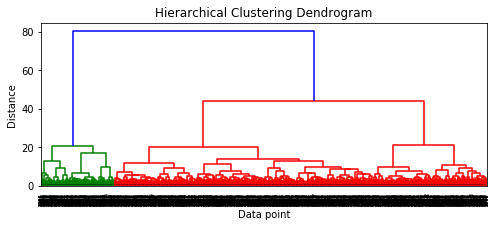

In [44]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [45]:
#I don't really understand this model but it seems really cool. Won't present without understanding but will look up.

In [46]:
#Clearly didn't really work since the clusters are so uneven, they don't really match the data.

## LDA

In [47]:
from sklearn.decomposition import LatentDirichletAllocation

In [48]:
x = df['text'] #titles and self text combined
y = df['subreddit']

In [49]:
lda = LatentDirichletAllocation(n_components=20, max_iter=100, random_state=13)

In [50]:
x_tf = tf.fit_transform(x)

In [51]:
tf_matrix = x_tf.toarray()
vocab = tf.get_feature_names()

In [52]:
lda_matrix = lda.fit_transform(tf_matrix)

In [53]:
lda_matrix

array([[0.00617512, 0.00617512, 0.00617512, ..., 0.00617512, 0.00617512,
        0.00617512],
       [0.00492325, 0.00492325, 0.00492325, ..., 0.00492327, 0.00492326,
        0.00492325],
       [0.00578445, 0.00578445, 0.00578445, ..., 0.00578445, 0.00578445,
        0.00578445],
       ...,
       [0.01367945, 0.01367945, 0.17388646, ..., 0.01367945, 0.01367945,
        0.01367945],
       [0.0074499 , 0.00744991, 0.0074499 , ..., 0.0074499 , 0.00744991,
        0.0074499 ],
       [0.00521595, 0.00521595, 0.00521595, ..., 0.00521595, 0.15698063,
        0.00521595]])

In [54]:
features = pd.DataFrame(lda_matrix, columns = list(range(20)))
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.006175,0.006175,0.006175,0.858002,0.006175,0.006175,0.019352,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.017670,0.006175,0.006175,0.006175,0.006175
1,0.004923,0.004923,0.004923,0.683133,0.052524,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923,0.180647,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923
2,0.005784,0.005784,0.005784,0.745539,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,0.150341,0.005784,0.005784,0.005784,0.005784
3,0.010866,0.010866,0.010866,0.532302,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.272110,0.010866
4,0.005067,0.005067,0.005067,0.667655,0.005067,0.005067,0.005067,0.005067,0.005067,0.005067,0.005067,0.005067,0.005067,0.005067,0.241138,0.005067,0.005067,0.005067,0.005067,0.005067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.650892,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374
3268,0.012111,0.012111,0.012111,0.530566,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,0.251438,0.012111,0.012111,0.012111
3269,0.013679,0.013679,0.173886,0.579883,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679
3270,0.007450,0.007450,0.007450,0.509831,0.007450,0.007450,0.356071,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450


In [55]:
y_df = pd.DataFrame(y)

In [56]:
topics = features.merge(y_df, left_index=True, right_index=True)

In [57]:
topics 

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,subreddit
0,0.006175,0.006175,0.006175,0.858002,0.006175,0.006175,0.019352,0.006175,0.006175,0.006175,...,0.006175,0.006175,0.006175,0.006175,0.017670,0.006175,0.006175,0.006175,0.006175,0
1,0.004923,0.004923,0.004923,0.683133,0.052524,0.004923,0.004923,0.004923,0.004923,0.004923,...,0.180647,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923,0.004923,0
2,0.005784,0.005784,0.005784,0.745539,0.005784,0.005784,0.005784,0.005784,0.005784,0.005784,...,0.005784,0.005784,0.005784,0.005784,0.150341,0.005784,0.005784,0.005784,0.005784,0
3,0.010866,0.010866,0.010866,0.532302,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,...,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.010866,0.272110,0.010866,0
4,0.005067,0.005067,0.005067,0.667655,0.005067,0.005067,0.005067,0.005067,0.005067,0.005067,...,0.005067,0.005067,0.005067,0.241138,0.005067,0.005067,0.005067,0.005067,0.005067,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.650892,...,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,0.018374,1
3268,0.012111,0.012111,0.012111,0.530566,0.012111,0.012111,0.012111,0.012111,0.012111,0.012111,...,0.012111,0.012111,0.012111,0.012111,0.012111,0.251438,0.012111,0.012111,0.012111,1
3269,0.013679,0.013679,0.173886,0.579883,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,...,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,0.013679,1
3270,0.007450,0.007450,0.007450,0.509831,0.007450,0.007450,0.356071,0.007450,0.007450,0.007450,...,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,0.007450,1


In [58]:
lr = LogisticRegression()

In [59]:
x = topics.drop('subreddit', axis = 1)
y = topics.subreddit

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)

In [61]:
lr.fit(x_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
lr.score(x_train, y_train)

0.5884270578647107

In [63]:
lr.score(x_test, y_test)

0.5733496332518337

In [64]:
rf = RandomForestClassifier(max_depth=5, n_estimators=200, max_leaf_nodes=5, max_features= 5)

rf.fit(x_train, y_train)

print(rf.score(x_train, y_train))

rf.score(x_test, y_test)

0.6251018744906276


0.6418092909535452

In [65]:
#printing out some topics to check them out

In [66]:
import pprint

In [67]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.9]
    pprint.pprint(topic)

[('favorite', 3.719722009917936),
 ('character', 3.074006992243567),
 ('compliments', 2.6245309754782546),
 ('spend', 1.9225075746962714),
 ('ur', 1.5532038979131224),
 ('excuse', 1.4505591254070302),
 ('secret', 1.4251514567372072),
 ('favourite', 1.4022385477719261),
 ('condoms', 1.3580539746093205),
 ('internship', 1.2928793952854976),
 ('navigate', 1.2765768544926233),
 ('websites', 1.2384779098195013),
 ('discriminated', 1.1987156457739978),
 ('cup', 1.1856263679217802),
 ('divorced', 1.1199570989616272),
 ('fictional', 1.0847297470471509),
 ('cheap', 1.0440356702987104),
 ('occasions', 1.0250469445872115),
 ('curved', 1.0120463887183702),
 ('nails', 0.9936944860635533),
 ('speaking', 0.9348395456687698),
 ('tissues', 0.9278703061448176),
 ('challenges', 0.9020350380906871)]
[('control', 1.4433328949409245),
 ('watch', 1.3583524983811055),
 ('connection', 1.132789190607135),
 ('phones', 1.0798561761404055),
 ('culture', 0.9461065069264712)]
[('compared', 2.212119321987588),
 ('tat

[('flirt', 2.5669259780474007),
 ('favorite', 2.5164344243161447),
 ('vs', 2.1999174761133045),
 ('fortnite', 1.8167006428296193),
 ('tv', 1.2876770306280907),
 ('judge', 1.2696558709597103),
 ('present', 1.167530277167642),
 ('feminist', 1.0393701364937835),
 ('jpg', 1.029973993793375),
 ('imgur', 1.022646990256842),
 ('rejection', 0.9485955737897145),
 ('dealbreaker', 0.9460926659874233),
 ('choose', 0.9275997175117215),
 ('green', 0.9128304759166409)]
[('weirdest', 2.6891859312040993),
 ('abusive', 1.8574713165133283),
 ('brand', 1.732092377744421),
 ('stupid', 1.653053478566449),
 ('cologne', 1.6219874978252986),
 ('sexiest', 1.5237655998058621),
 ('polish', 1.4551893767588184),
 ('nail', 1.4145053122200244),
 ('confessed', 1.289177537476907),
 ('disgusting', 1.2731422506107846),
 ('liked', 1.2320875549580779),
 ('cool', 1.2041232887705269),
 ('growing', 1.133584264880111),
 ('favourite', 1.1262891641298742),
 ('learning', 1.0981955224847333),
 ('asian', 1.030404409421456),
 ('favo

In [68]:
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.9]
    pprint.pprint(topic)

[('favorite', 3.719722009917936),
 ('character', 3.074006992243567),
 ('compliments', 2.6245309754782546),
 ('spend', 1.9225075746962714),
 ('ur', 1.5532038979131224),
 ('excuse', 1.4505591254070302),
 ('secret', 1.4251514567372072),
 ('favourite', 1.4022385477719261),
 ('condoms', 1.3580539746093205),
 ('internship', 1.2928793952854976),
 ('navigate', 1.2765768544926233),
 ('websites', 1.2384779098195013),
 ('discriminated', 1.1987156457739978),
 ('cup', 1.1856263679217802),
 ('divorced', 1.1199570989616272),
 ('fictional', 1.0847297470471509),
 ('cheap', 1.0440356702987104),
 ('occasions', 1.0250469445872115),
 ('curved', 1.0120463887183702),
 ('nails', 0.9936944860635533),
 ('speaking', 0.9348395456687698),
 ('tissues', 0.9278703061448176),
 ('challenges', 0.9020350380906871)]
[('control', 1.4433328949409245),
 ('watch', 1.3583524983811055),
 ('connection', 1.132789190607135),
 ('phones', 1.0798561761404055),
 ('culture', 0.9461065069264712)]
[('compared', 2.212119321987588),
 ('tat

 ('tells', 4.048280260136842),
 ('living', 4.033579729682461),
 ('wanting', 4.028875196774952),
 ('crazy', 4.021178697273767),
 ('opinions', 4.018885029171947),
 ('girlfriends', 3.9827894394792924),
 ('least', 3.9816555872617214),
 ('flirting', 3.9701166555855414),
 ('support', 3.9694793102228854),
 ('difficult', 3.968434036486506),
 ('decide', 3.9656778110088386),
 ('hi', 3.9565052671191925),
 ('appreciated', 3.9562385149570685),
 ('dislike', 3.938463403244333),
 ('room', 3.93553674400877),
 ('balls', 3.924075973578531),
 ('equivalent', 3.924036735550772),
 ('view', 3.9175348242523937),
 ('differently', 3.894858813363636),
 ('based', 3.880198237207253),
 ('confidence', 3.869480038950486),
 ('whatever', 3.852244870621971),
 ('mental', 3.8520869852553106),
 ('choose', 3.8502700886399004),
 ('month', 3.8497148110919692),
 ('dinner', 3.8395495891144376),
 ('extra', 3.8389066373686402),
 ('figure', 3.834861280340972),
 ('future', 3.834392910371216),
 ('keeps', 3.828115346909235),
 ('worse'

 ('typical', 1.4451261015564942),
 ('brothers', 1.4406065304846885),
 ('grab', 1.4374341960521169),
 ('marry', 1.4348892721543174),
 ('desirable', 1.429351287619293),
 ('intimacy', 1.4287520029166703),
 ('pms', 1.4270583996789983),
 ('mentioned', 1.4262632604233934),
 ('split', 1.424290643952281),
 ('income', 1.422743490285388),
 ('saturday', 1.4202568554279613),
 ('mixed', 1.4107438171999724),
 ('stopping', 1.4069795813454407),
 ('invited', 1.4061432370854918),
 ('soul', 1.402447937554183),
 ('vaginas', 1.394607503655186),
 ('door', 1.3944219424713544),
 ('complete', 1.3912424773848906),
 ('military', 1.3890972757653346),
 ('luck', 1.3889558903023056),
 ('degree', 1.3859342938094474),
 ('verbal', 1.3778276786701062),
 ('fairly', 1.3768309802471204),
 ('fully', 1.3755937432742995),
 ('closest', 1.3755736725171614),
 ('casually', 1.3754020256525838),
 ('opening', 1.3752010911059196),
 ('slowly', 1.3746282679453798),
 ('stores', 1.3742053609937335),
 ('smart', 1.3717572145328967),
 ('pri

[('toilet', 2.7307657182465332),
 ('seat', 2.054282261418877),
 ('tits', 1.676277055300717),
 ('dirty', 1.4506706104349618),
 ('longest', 1.184632154464506),
 ('unisex', 1.1357001181183548),
 ('diary', 1.094246995133135),
 ('bh', 1.0499999999994731),
 ('fiction', 1.0431367720409692),
 ('journal', 1.0275255310436355),
 ('choice', 1.0133425990003901),
 ('favorite', 0.9761479071953941),
 ('pic', 0.9675135474902978),
 ('unhealthy', 0.9643829873471301),
 ('patterns', 0.9420788522454827)]
[('pee', 2.6471912906252673),
 ('learn', 2.2696160746859637),
 ('average', 2.253512635924413),
 ('favorite', 2.21681855572004),
 ('heard', 1.9907193605825568),
 ('memory', 1.8121936726937253),
 ('condom', 1.7714567606827207),
 ('cum', 1.7428270093977554),
 ('dose', 1.575038234937613),
 ('woke', 1.5012710422323647),
 ('dance', 1.4861777363023971),
 ('instagram', 1.4342738173106193),
 ('owned', 1.38201130701709),
 ('use', 1.3465811905350387),
 ('wtf', 1.334405447798081),
 ('list', 1.2835275565333344),
 ('bra'

In [69]:
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.9]
    pprint.pprint(topic[3])

('spend', 1.9225075746962714)
('phones', 1.0798561761404055)
('gender', 1.6149240509667566)
('what', 159.33937418894254)
('amazing', 2.7454729556417017)
('fortnite', 1.8167006428296193)
('stupid', 1.653053478566449)
('beard', 2.2282308813559357)
('dumped', 1.9690035618870023)
('taught', 0.9663677694327902)
('song', 1.2058046790890076)
('dirty', 1.4506706104349618)
('favorite', 2.21681855572004)
('oral', 1.4862544442377024)
('dog', 1.4592872123551526)
('valentine', 2.157047011333164)
('saw', 1.6893820553465806)
('pussy', 2.051011502212303)
('loneliness', 1.3340369031335557)
('sweetest', 1.3427404165381542)


In [70]:
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.9]
    pprint.pprint(topic[4])

('ur', 1.5532038979131224)
('culture', 0.9461065069264712)
('improve', 1.5539402900610169)
('the', 158.80517372368047)
('cause', 2.7169847390966892)
('tv', 1.2876770306280907)
('cologne', 1.6219874978252986)
('secure', 1.9694291168440587)
('achieve', 1.8058652236917732)


IndexError: list index out of range